# Deep Learning from Audio Signals

### Training a MLP on MFCC features generated from Genre music files

Rajesh Siraskar | 03-May-2021

- Load data
- Split into train/test
- Build MLP network architecture
- Compile network
- Train network

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
%matplotlib inline

### Load data

In [2]:
# DATA_PATH = "audio_files/genres_REDUCED/"
JSON_FILE = "audio_files/mfcc_json.json"
NUMBER_OF_CLASSES = 4 # Reduced set has only 4 genres

In [3]:
def load_data (json_file):
    with open(json_file, "r") as fp:
        data = json.load(fp)
        
        # Note: mfcc was converted from a numpy array to list before storing in JSON
        #  Need convert back to numpy array
        X = np.array(data["mfcc"])
        y = np.array(data["labels"])
        
    return X, y

In [4]:
def plot_history (history, regularization_flag=False):

    fig, axs = plt.subplots(2, figsize=(12, 8)) # width, height
    
    # Accuracy sub-plot
    axs[0].plot(history.history["accuracy"], label="Training accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_facecolor('#FFFFF0') # little darker biege: #F5F5DC
    if regularization_flag: axs[0].set_title("Accuracy plot (with regularizatiton)")
    else: axs[0].set_title("Accuracy plot")
    
    # Error (loss) sub-plot
    axs[1].plot(history.history["loss"], label="Training error")
    axs[1].plot(history.history["val_loss"], label="Test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epochs")   
    axs[1].legend(loc="upper right")
    axs[1].set_facecolor('#FFFFF0')
    if regularization_flag: axs[1].set_title("Error plot (with regularizatiton)")
    else: axs[1].set_title("Error plot")
    

    plt.show()

### Main function
- Network: 
    - 1 input  = Flatten 3-D numpy array and use only 2-Ds (mfcc and hop-length)
    - 3 hidden = 512 x 256 x 64. Activation = ReLU
    - 1 output = Number of classes (genres). 4 genres. Activation = softmax  
- Mini-batch
- Adam optimization
- Learning-rate=0.0001

In [5]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
#     i/p, 3 hidden, o/p and all fully-connected (i.e. dense)
model = keras.Sequential([
    # Input layer: 
    #   input json is a 3D file: We ignore 1st dim and consider only 2nd and 3rd dims
    #   MFCC for each segment, and each mfcc is a vector over an interval = hop-length
    #   - dimension 1: num_segments x n_classes x .wav-files-per-class 
    #   - dimension 2: num_mfcc_vectors_per_segment = math.ceil(samples_per_segment/hop_length)
    #   - dimension 3: num_mfcc
    #   X.shape[1] = dim-2 and X.shape[2]=dim-2
    #   first-dim: interval = inputs.shape[1]
    #   second-dim: mfcc = inputs.shape[2]
    #   NOTE: inputs.shape[0] is the segment number and we are not passing that
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # 1st hidden-layer:
    #   Use ReLU instead of sigmoid. Much faster.
    #   ReLU better convergence. Reduce likelihood of vanishing gradients
    #   Vanishing gradients: Multiply error by derivative of activation fn.
    #   Sigmoid fn. derivative = 0.25. Keep multiplying by 0.25, gradient becomes smaller and smaller
    #   and *vanishes*
    keras.layers.Dense(512, activation="relu"),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu"),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu"),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history = model.fit(X_train, y_train,                 # Training data
                    validation_data=(X_test, y_test), # Test data
                    epochs=50,
                    batch_size=32) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 1,013,828
Trainable params: 1,013,828
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 3s 2s/step - loss: 43.2371 - accuracy: 0.3170 - val_loss: 35.4

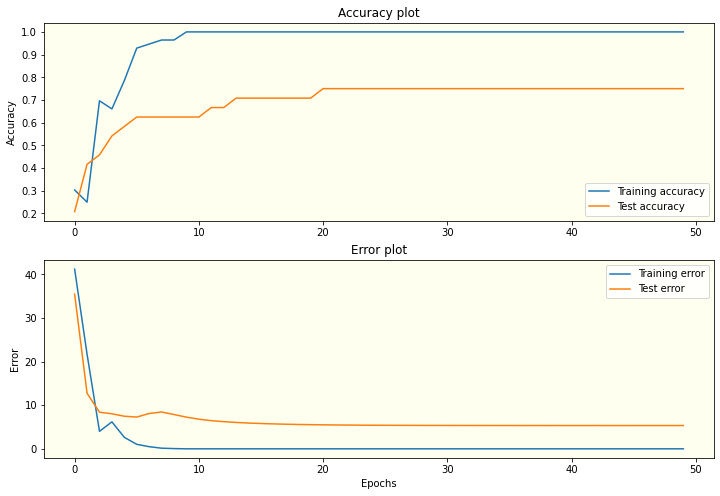

In [6]:
## 6. Plot training curves - NO regularization
plot_history(history, regularization_flag=False)

### Reducing Over-fitting
- 5 techniques
    - Simpler architecture
    - Data-augmentation: Pitch change, Time-stretching, Add noise
    - Early stopping
    - Drop-out
    - Regularization    

- **Drop-out**: NN can't depend on any particular neuron and tries to spread out weights and makes ot robust
- **Regularization**: 
    - Add penalty to error function
    - Punish large weigths
    - L1: Minimize absolute values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|$
    - L2: Minimize _squared_ values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|^2$
    - L1: Robust to outliers, simpler model
    - L2: NOT robust to outliers, learns complex patterns

In [7]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # Hidden-layers: With added Dropout amd Regularization with Lambda=0.001
    # 1st hidden-layer:
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history_reg = model.fit(X_train, y_train,                 # Training data
                        validation_data=(X_test, y_test), # Test data
                        epochs=100,
                        batch_size=32)  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

Epoch 49/100
2/2 [==============================] - 0s 45ms/step - loss: 5.6283 - accuracy: 0.7738 - val_loss: 7.1005 - val_accuracy: 0.7500
Epoch 50/100
2/2 [==============================] - 0s 46ms/step - loss: 5.9574 - accuracy: 0.8065 - val_loss: 8.9369 - val_accuracy: 0.7083
Epoch 51/100
2/2 [==============================] - 0s 43ms/step - loss: 5.8231 - accuracy: 0.8408 - val_loss: 11.3893 - val_accuracy: 0.6667
Epoch 52/100
2/2 [==============================] - 0s 42ms/step - loss: 3.1938 - accuracy: 0.8735 - val_loss: 13.6682 - val_accuracy: 0.6250
Epoch 53/100
2/2 [==============================] - 0s 43ms/step - loss: 3.4328 - accuracy: 0.8988 - val_loss: 15.0488 - val_accuracy: 0.6250
Epoch 54/100
2/2 [==============================] - 0s 41ms/step - loss: 3.3329 - accuracy: 0.8765 - val_loss: 16.0268 - val_accuracy: 0.6250
Epoch 55/100
2/2 [==============================] - 0s 41ms/step - loss: 1.4958 - accuracy: 0.9315 - val_loss: 16.4756 - val_accuracy: 0.6250
Epoch 56

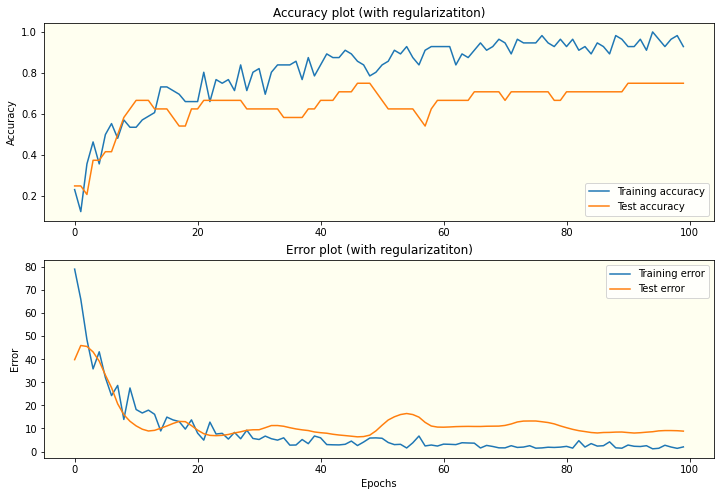

In [8]:
## 6. Plot training curves - With drop-out and L2 regularization
plot_history(history_reg, regularization_flag=True)